In [1]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import pickle
from lib import read_file,gateset_string

# mpl cosmetics
import matplotlib as mpl
from matplotlib.lines import lineMarkers
from matplotlib.colors import BASE_COLORS
import matplotlib.patches as mpatches
lineMarkers = tuple(lineMarkers.keys())
baseColors = tuple(BASE_COLORS.keys())

In [2]:
# reading the data from the pickled file
therm_data_CNOT = ()
therm_data_iSWAP = ()
beta_data = ()

# thermalization for different gate sets
therm_data_CNOT += read_file("data/07-02_22-30-12___data.pickle") # (CNOT,H,Z)
therm_data_CNOT += read_file("data/07-02_19-40-49___data.pickle") # (CNOT,H,X)
therm_data_CNOT += read_file("data/07-02_19-40-58___data.pickle") # (CNOT,H,S)
therm_data_CNOT += read_file("data/07-02_19-41-03___data.pickle") # (CNOT,H,T)

therm_data_iSWAP += read_file("data/07-02_22-33-37___data.pickle")

# thermalization for different (inverse) temperatures beta
beta_data += read_file("data/07-02_19-44-30___data.pickle")

File data/07-02_22-30-12___data.pickle is over.
File data/07-02_19-40-49___data.pickle is over.
File data/07-02_19-40-58___data.pickle is over.
File data/07-02_19-41-03___data.pickle is over.
File data/07-02_22-33-37___data.pickle is over.
File data/07-02_19-44-30___data.pickle is over.


In [3]:
def thermalization_timeline_plot(datasets:tuple[dict],fname:str="",savefig:bool=False):
    """
    Plots thermalization (heating and cooling) for all simulation data in `datasets`. Separate plots are created
    for every gate set, and saved under `writing/plots/`.
    """
    # finding the gate for which we have simulation data
    gate_sets = ()
    for dataset in datasets:
        if dataset["gate_set"] not in gate_sets: gate_sets += (dataset["gate_set"],)

    # plotting
    for gate_set in gate_sets:
        fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,4))
        for dataset in datasets:
            if dataset["gate_set"] == gate_set:
                step_axis = np.arange(dataset["heating"]["nSteps"]+dataset["cooling"]["nSteps"]+2)
                ax.plot(step_axis,np.concatenate((dataset["Svn_heating"].mean(axis=(0,2)),dataset["Svn_cooling"].mean(axis=(0,2)))),label="N = {}".format(dataset["heating"]["nWires"]))
        ax.set_xlabel("#step")
        ax.set_xscale("log")
        ax.set_title("gate set " + gateset_string(gate_set))
        ax.set_ylabel(r"$\langle S_{\chi}\rangle$")
        ax.legend(loc="upper left")
    
        if savefig:
            fig.savefig("writing/plots/therm_" + gateset_string(gate_set) + fname + ".pdf",bbox_inches="tight")

def beta_plot(datasets:tuple[dict],fname:str="",savefig:bool=False):
    """
    Plots the cooling process for every value of beta, where beta is included as a colormap. A separate plot is created for
    every gate set, for which there is simulation data present in `datasets`. Plots are saved under `writing/plots/`.
    """
    # finding the gates and betas for which we have simulation data
    gate_sets = ()
    beta_axis = ()
    for dataset in datasets:
        if dataset["gate_set"] not in gate_sets: gate_sets += (dataset["gate_set"],)
        if dataset["cooling"]["beta"] not in beta_axis: beta_axis += (dataset["cooling"]["beta"],)

    cmap = mpl.colormaps["plasma"]

    for gate_set in gate_sets:
        fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,4))
        for dataset in datasets:
            if dataset["gate_set"] == gate_set:
                step_axis = np.arange(dataset["cooling"]["nSteps"]+1)
                ax.plot(
                    step_axis,
                    dataset["Svn_cooling"].mean(axis=(0,2)),
                    label=r"$\beta$ = {}".format(dataset["cooling"]["beta"]),
                    c=cmap((dataset["cooling"]["beta"] - min(beta_axis)) / (max(beta_axis) - min(beta_axis)))
                )
        ax.set_xlabel("#step")
        ax.set_xscale("log")
        ax.set_title("gate set " + gateset_string(gate_set))
        ax.set_ylabel(r"$\langle S_{\chi}\rangle$")
        fig.colorbar(plt.cm.ScalarMappable(mpl.colors.Normalize(vmin=min(beta_axis),vmax=max(beta_axis)),cmap="plasma"),ax=ax,label=r"$\beta$")

        if savefig:
            fig.savefig("writing/plots/betatest_" + gateset_string(gate_set) + fname + ".pdf",bbox_inches="tight")

def therm_speed_plot(datasets:tuple[dict],fname:str="",savefig:bool=False):
    """
    Plotting the cooling procedure for each gate set in `datasets` separately, where the number of wires in
    the system is color-coded in a colormap. One plot is created and saved under `writing/plots/`.
    """
    # starting value of mean entanglement entropy at the beginning of the cooling procedure, for each gate set, and number of Wires
    S0 = {}
    nWires_axis = ()
    for dataset in datasets:
        if dataset["gate_set"] not in S0.keys(): S0[dataset["gate_set"]] = {}
        # starting value of entanglement entropy
        S0[dataset["gate_set"]][dataset["heating"]["nWires"]] = dataset["Svn_cooling"].mean(axis=(0,2))[0]
        # number of wires
        if dataset["heating"]["nWires"] not in nWires_axis: nWires_axis += (dataset["heating"]["nWires"],)

    cmap = mpl.colormaps["plasma"]

    # ordering the gate sets according to which one reduces entanglement entropy by the largest amount
    deltaS = {}
    for dataset in datasets:
        if dataset["gate_set"] not in deltaS.keys(): deltaS[dataset["gate_set"]] = 0
        Sinit = dataset["Svn_cooling"].mean(axis=(0,2))[0]
        Slast = dataset["Svn_cooling"].mean(axis=(0,2))[-1]

        if Slast - Sinit < deltaS[dataset["gate_set"]]: deltaS[dataset["gate_set"]] = Slast - Sinit
    gate_sets_to_deltaS = [[gate_set for gate_set in deltaS.keys()],] + [[deltaS[gate_set] for gate_set in deltaS.keys()],]
    mask = np.argsort(gate_sets_to_deltaS[1])[::-1]

    # Offsets for every gate set, such that they start from different points on the y-axis and can be distinguished
    gate_set_offsets = {gate_sets_to_deltaS[0][iSet]:-i for i,iSet in enumerate(mask)}

    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,4))
    for dataset in datasets:
        step_axis = np.arange(dataset["cooling"]["nSteps"]+1)
        ax.plot(
            step_axis,
            dataset["Svn_cooling"].mean(axis=(0,2)) - S0[dataset["gate_set"]][dataset["heating"]["nWires"]] + gate_set_offsets[dataset["gate_set"]],
            label="N = {}".format(dataset["heating"]["nWires"]),
            c=cmap((dataset["heating"]["nWires"] - min(nWires_axis)) / (max(nWires_axis) - min(nWires_axis)))
        )
    ax.tick_params(axis="y",rotation=0,left=False,pad=-70)
    ax.set_xlabel("#step")
    ax.set_ylabel(r"$\langle S_{\chi}\rangle$")
    ax.set_yticks([gate_set_offsets[key]-0.3 for key in gate_set_offsets.keys()])
    ax.set_yticklabels([gateset_string(key) for key in gate_set_offsets.keys()])
    ax.set_xscale("log")
    # ax.legend()
    fig.colorbar(plt.cm.ScalarMappable(mpl.colors.Normalize(vmin=min(nWires_axis),vmax=max(nWires_axis)),cmap="plasma"),ax=ax,label=r"system size $N$")

    if savefig:
        fig.savefig("writing/plots/therm_speed" + fname + ".pdf",bbox_inches="tight")


# Plots for thermalization

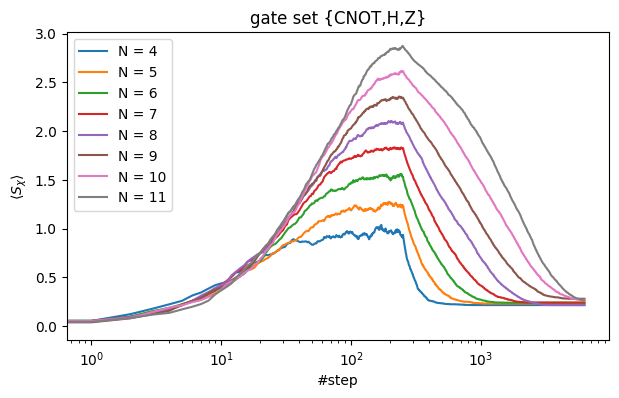

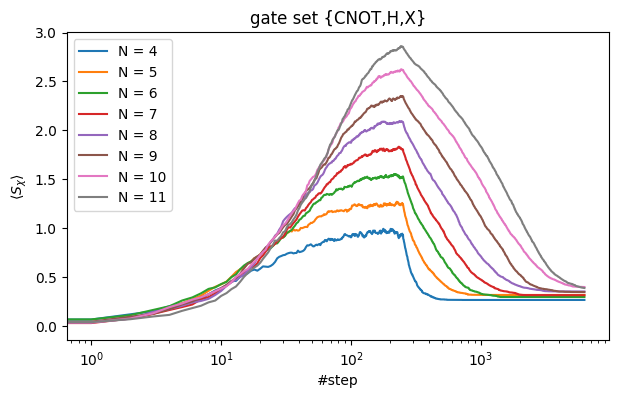

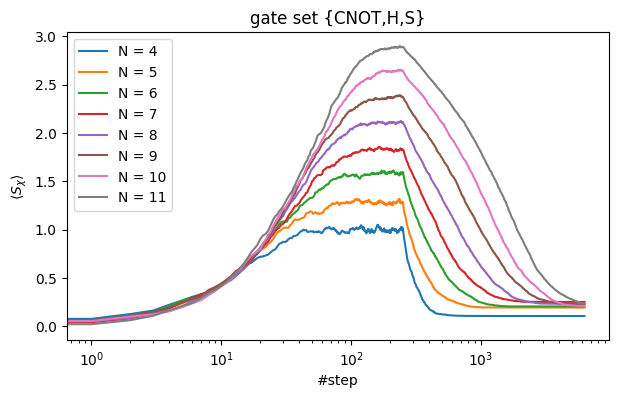

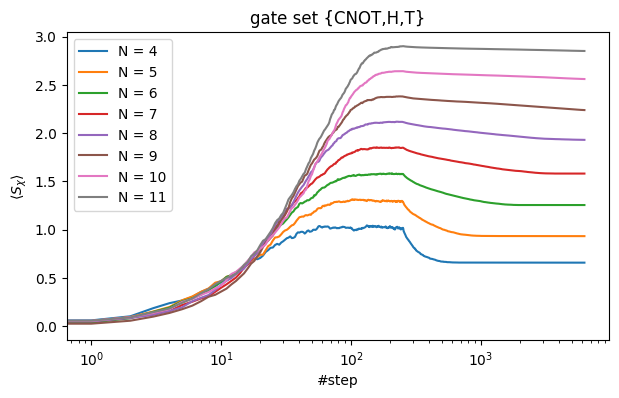

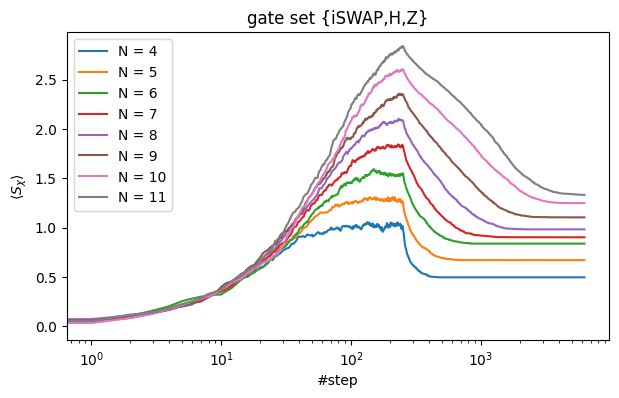

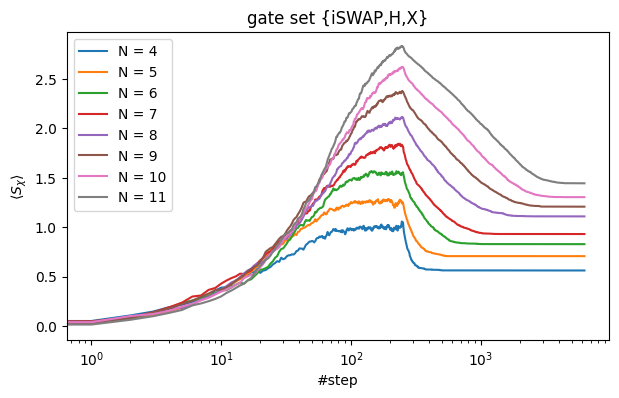

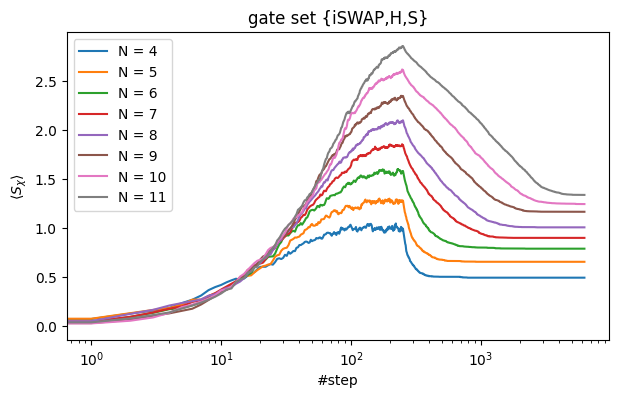

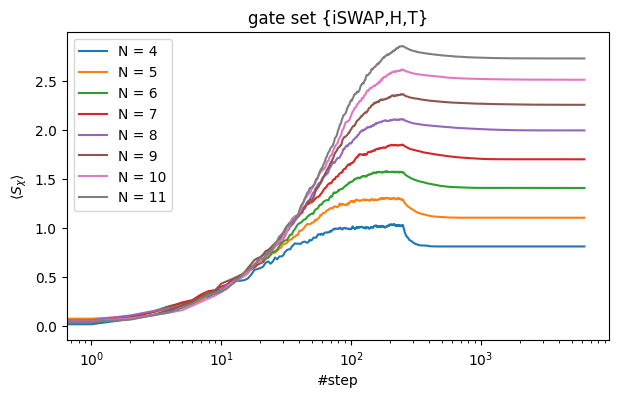

In [4]:
thermalization_timeline_plot(therm_data_CNOT,savefig=True)
thermalization_timeline_plot(therm_data_iSWAP,savefig=True)

# Plots for different temperatures $\beta$

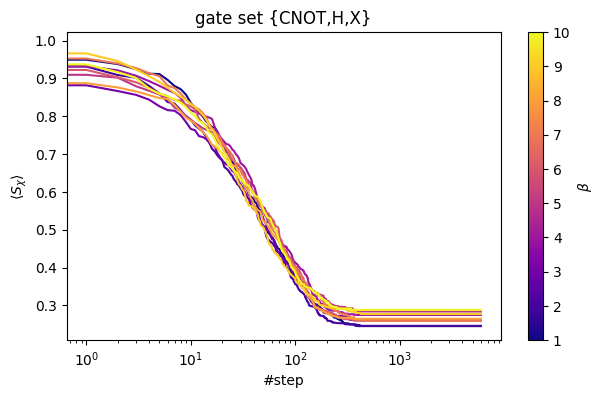

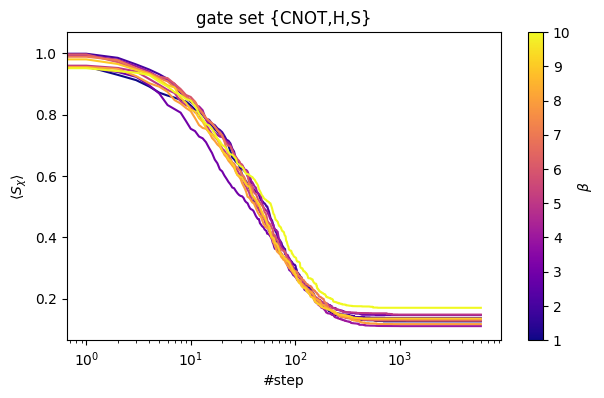

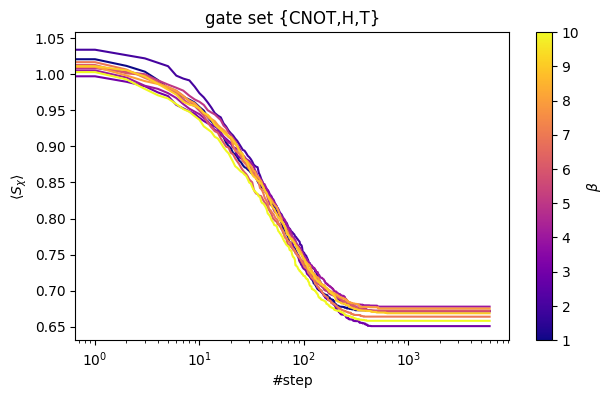

In [5]:
beta_plot(beta_data,fname="_CNOT",savefig=True)

# Effect of system size on thermalization

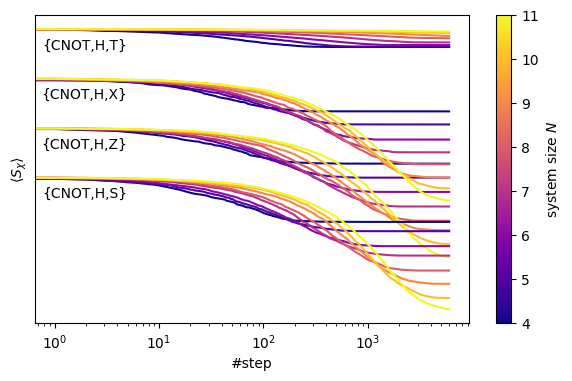

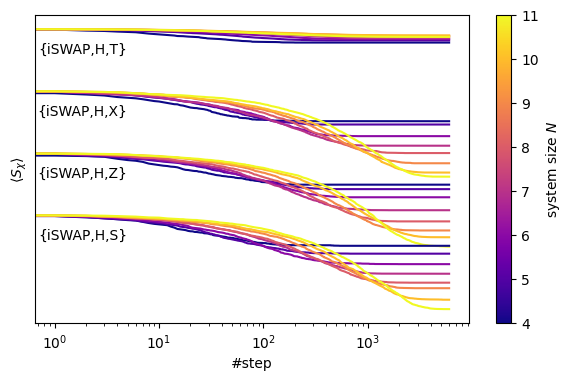

In [6]:
therm_speed_plot(therm_data_CNOT,fname="_CNOT",savefig=True)
therm_speed_plot(therm_data_iSWAP,fname="_iSWAP",savefig=True)